# HJ-Reachability - Value Function Approximation

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()
import seaborn as sns

In [2]:
import os

import mantrap
import numpy as np
import pandas as pd
import torch

t_horizon = 5

env = mantrap.environment.Trajectron(mantrap.agents.DoubleIntegratorDTAgent, 
                                     ego_position=torch.zeros(2))
_  = env.add_ado(position=torch.rand(2) * 4, velocity=torch.rand(2))

In [3]:
file_baseline = "2D_large.mat"
module_baseline = mantrap.modules.HJReachabilityModule(env, t_horizon=t_horizon, data_file=file_baseline)

# Loading accuartely computed value function and compute meshgrid containing every computed grid coordinate.
_, _, grid_size_by_dim, _, (grid_min, grid_max) = mantrap.modules.HJReachabilityModule.unpack_mat_file(
    mat_file_path=os.path.join(mantrap.utility.io.build_os_path("third_party/reachability"), file_baseline)
)
x_grid, y_grid, vx_grid, vy_grid = np.meshgrid(*(np.linspace(grid_min[i], grid_max[i], num=grid_size_by_dim[i]) \
                                                 for i in range(4)))
mesh = np.stack((x_grid.flatten(), y_grid.flatten(), vx_grid.flatten(), vy_grid.flatten())).T

# In order to reduce the number of evaluation points, sample 1000 random points.
idx = np.random.randint(low=0, high=mesh.shape[0] - 1, size=1000)
mesh = mesh[idx, :]
print(f"Meshgrid with {mesh.shape[0]} elements ready for evaluation !")

Meshgrid with 1000 elements ready for evaluation !


In [4]:
# Evaluate value function error of approximation.
models = {"small": "2D_small.mat", "interior": "2D_interior.mat", "medium": "2D_medium.mat"}

results_df = pd.DataFrame(columns=["model", "error", "x", "y", "vx", "vy"])
for label, file_name in models.items():
    print(label, file_name)
    module = mantrap.modules.HJReachabilityModule(env, t_horizon=t_horizon, data_file=file_name)
    
    for x_rel in mesh:
        error = module.value_function(x_rel) - module_baseline.value_function(x_rel)
        results_df = results_df.append({"model": label, "error": float(error), 
                                        "x": x_rel[0], "y": x_rel[1], "vx": x_rel[2], "vy": x_rel[3]}, 
                                        ignore_index=True)

small 2D_small.mat
interior 2D_interior.mat
medium 2D_medium.mat


In [5]:
results_df["log_error"] = np.log(np.abs(results_df["error"]) + 1e-10)  # avoiding nan values (log(0)/log(-x))
results_df

,model,error,x,y,vx,vy,log_error
0,small,0.102738,-4.5,-24.0,1.5,-0.5,-2.275570
1,small,-0.356442,3.0,1.5,-1.8,-2.0,-1.031585
2,small,1.302450,-22.5,18.0,0.9,1.8,0.264247
3,small,0.611679,30.0,-10.5,-1.6,-0.2,-0.491548
4,small,-1.013207,9.0,18.0,-1.3,-1.8,0.013121
...,...,...,...,...,...,...,...
2995,medium,-0.002578,-15.0,-27.0,-2.0,1.6,-5.960809
2996,medium,-0.888628,22.5,30.0,1.9,1.7,-0.118076
2997,medium,-1.304052,-9.0,13.5,1.0,1.4,0.265476
2998,medium,0.770630,16.5,-28.5,-0.6,-1.1,-0.260546


In [7]:
# Plot results as bar plot.
ax = sns.boxplot(x="log_error", y="model", data=results_df)
plt.show()

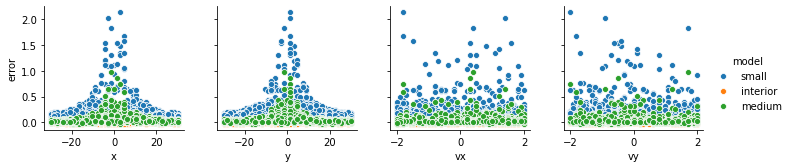

In [7]:
ax = sns.pairplot(data=results_df, hue="model", y_vars=["error"], x_vars=["x", "y", "vx", "vy"], diag_kind="kde")
plt.show()